# PREDICTION OF SS AND DETECT MOST IMPORTANT FEATURES 

# Prepare the data 

In [3]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

# Create train data with one hot encoding for MLL
severity_train = pd.read_csv("train_handmade.csv", sep=';')
mll_train = pd.get_dummies(severity_train["MLL"])
severity_train = pd.concat([severity_train, mll_train], axis=1)

# Create test data with one hot encoding for MLL
severity_test = pd.read_csv("test_handmade.csv", sep=';')
mll_test = pd.get_dummies(severity_test["MLL"])
severity_test = pd.concat([severity_test, mll_test], axis=1)

# Drop the MLL column that is useless now  
severity_train = severity_train.drop(columns="MLL", axis=1)
severity_test = severity_test.drop(columns="MLL", axis=1)

# get same columns for train and test data
missing_cols = set(severity_train.columns) - set(severity_test.columns)

for c in missing_cols:
    severity_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
severity_test = severity_test[severity_train.columns]

# don t forget to drop the SS columns which was added because present in the train but not in the test
severity_test = severity_test.drop("severity score", axis=1)


In [4]:
trainSize = severity_train.shape[0]
#severity_train["severity score"] = severity_train["severity score"].apply(np.log)
print(severity_test.shape)
print(severity_train.shape)

(12, 23)
(30, 24)


In [5]:
train_names = severity_train["name"]
test_names = severity_test["name"]

severity_test.drop("name", axis=1, inplace=True)
severity_train.drop("name", axis=1, inplace=True)

# (We dont ignore the na or missing in train data) 

In [6]:
import numpy as np
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor #as gbr as rfr

from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [11]:
rs_const = 80 #always use the same one value for all model tuning process
test_ratio_const = 0.2 
train_data   = severity_train.drop("severity score", axis=1)
train_target = severity_train[['severity score']]
test_data    = severity_test

X_train, X_test, y_train, y_test = train_test_split(train_data, train_target,\
                                                    test_size=test_ratio_const, random_state=rs_const)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

In [7]:
# 1. linear regression:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

RMSE train: 5.9854734177700685e-15
RMSE test : 3.3232593448441795e-15


In [8]:
# 2. ridge
grid_param = [{'alpha': np.logspace(-4, 4, 20)}]

gs = GridSearchCV(estimator=linear_model.Ridge(random_state=rs_const), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))

Best params: {'alpha': 0.0006951927961775605}
Best score : 0.9900328510725561
RMSE train: 0.00021124096376413758
RMSE test : 0.0011989264704252269


In [9]:
pd.Series(model.coef_.flatten()).describe()

count    22.000000
mean      0.012442
std       0.370101
min      -0.469053
25%      -0.000097
50%      -0.000038
75%       0.000043
max       1.531011
dtype: float64

In [10]:
# 3. lasso 
# max_iter = 1000, if not enough better increase alpha to proceed, 
# but not increase max_iter, as it mostly won't help much on the slow convergence. 
grid_param = [{'alpha': np.logspace(-3, 4, 20)}] 

gs = GridSearchCV(estimator=linear_model.Lasso(random_state=rs_const, normalize=False), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))

Best params: {'alpha': 0.001}
Best score : 0.9999990270823739
RMSE train: 0.0014745838369248246
RMSE test : 0.00111618475553239


In [11]:
sum(model.coef_ > 1e-6) / model.coef_.shape[0]


0.09090909090909091

In [12]:
# 4. ElasticNet
grid_param = [{'alpha': np.logspace(-2, 4, 20), 'l1_ratio': np.linspace(0.015, 1, 20)}]

# Confirmed that setting scoring='neg_mean_squared_error' is the same result as using the default "R2" score.
gs = GridSearchCV(estimator=linear_model.ElasticNet(random_state=rs_const), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))


Best params: {'alpha': 0.01, 'l1_ratio': 0.9481578947368421}
Best score : 0.9999195210936582
RMSE train: 0.0131050677311875
RMSE test : 0.007267104110849478


In [13]:
sum(model.coef_ > 1e-6) / model.coef_.shape[0]


0.09090909090909091

In [14]:

grid_param = [{}]

# Step
#learning_rate:0.1 -> 0.05 -> 0.01 -> 0.005 ->... 0.005 best
#n_estimators: 140 -> 280  -> 1000 -> 2000  ->... 3000 best

gs = GridSearchCV(estimator = GradientBoostingRegressor(\
                                    learning_rate=0.005,\
                                    n_estimators=3000,\
                                    max_depth=5,\
                                    min_samples_split=7,\
                                    min_samples_leaf=1,\
                                    max_features='sqrt',\
                                    subsample=0.88,\
                                    random_state=rs_const), \
                                    param_grid = grid_param,\
                                    n_jobs=4, cv=5)  

gs.fit(X_train, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

Best params: {}
Best score : 0.7438200688740535
RMSE train: 0.0022152072263547703
RMSE test : 0.7315278908323091


In [15]:
model = GradientBoostingRegressor(\
                                    learning_rate=0.005,\
                                    n_estimators=1000,\
                                    max_depth=5,\
                                    min_samples_split=7,\
                                    min_samples_leaf=1,\
                                    max_features='sqrt',\
                                    subsample=0.88,\
                                    random_state=rs_const)
model.fit(X_train, y_train)

print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

RMSE train: 0.09538985993336041
RMSE test : 0.7425175767736292


In [16]:
print('sqrt total feature: {}'.format(math.sqrt(X_train.columns.shape[0])))
print('40% of total feature: {}'.format(X_train.columns.shape[0] * 0.4))

sqrt total feature: 4.69041575982343
40% of total feature: 8.8


<AxesSubplot:xlabel='feature_importance', ylabel='index'>

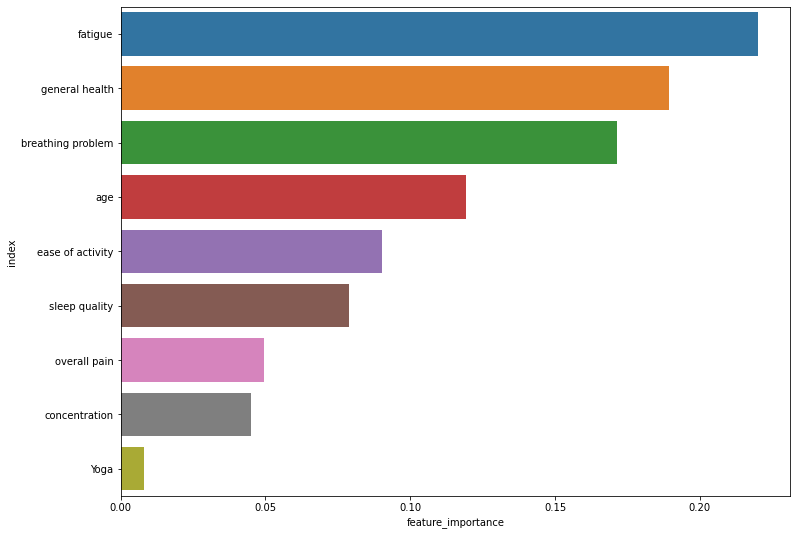

In [17]:
varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:9,], ax = ax)


In [18]:
grid_param = [{}]

gs = GridSearchCV(estimator = RandomForestRegressor(\
                                    max_features=4,\
                                    n_estimators=200,\
                                    min_samples_split=5,\
                                    min_samples_leaf=1,\
                                    random_state=rs_const,\
                                    n_jobs=-1),\
                  param_grid = grid_param, n_jobs=-1, cv=5)  

gs.fit(X_train, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))


Best params: {}
Best score : 0.5436137664604292
RMSE train: 0.5753052207294049
RMSE test : 0.7899363361338225


In [19]:
display(model)


RandomForestRegressor(max_features=4, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=80)

<AxesSubplot:xlabel='feature_importance', ylabel='index'>

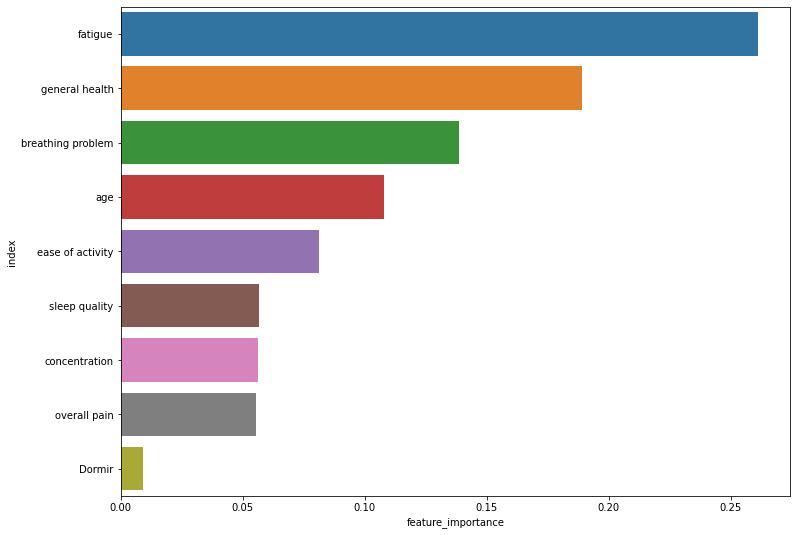

In [20]:
varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:9,], ax = ax)


RMSE train: 0.5753052207294049
RMSE test : 0.7899363361338225


<AxesSubplot:xlabel='feature_importance', ylabel='index'>

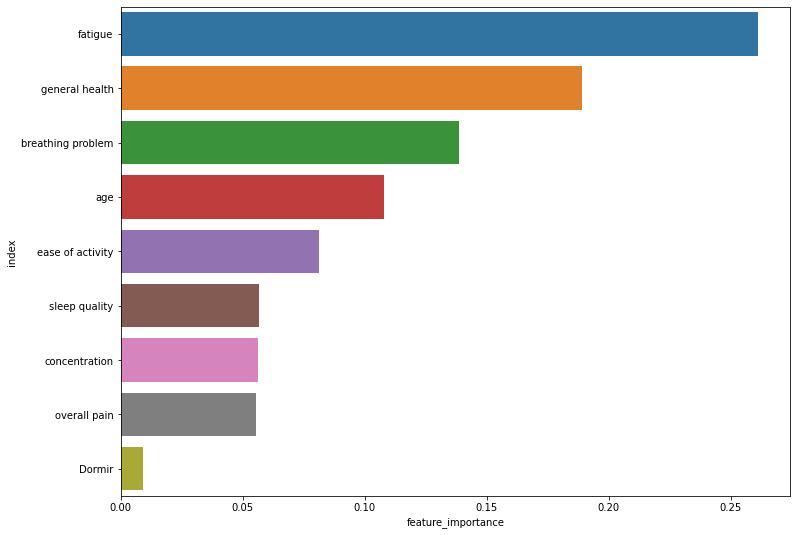

In [21]:
# RF best/try:
model = RandomForestRegressor(\
            max_features=4,\
            n_estimators=200,\
            min_samples_split=5,\
            min_samples_leaf=1,\
            random_state=rs_const,\
            n_jobs=-1)

model.fit(X_train, y_train)
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:9,], ax = ax)

In [22]:
# best multi model stacking: 
models = [
    # linear model
    #linear_model.Lasso(alpha=0.00545559478116852, random_state=rs_const),
    linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=rs_const),
 
    # conservative random forst model
#     RandomForestRegressor(\
#                         max_depth=5,\
#                         max_features='sqrt',\
#                         n_estimators=1000,\
#                         random_state=rs_const,\
#                         n_jobs=-1),
    
    RandomForestRegressor(\
                        max_features=4,\
                        n_estimators=200,\
                        min_samples_split=5,\
                        min_samples_leaf=1,\
                        random_state=rs_const,\
                        n_jobs=-1),
#     RandomForestRegressor(\
#                         max_depth=None,\
#                         max_features=80,\
#                         n_estimators=170,\
#                         random_state=rs_const,\
#                         n_jobs=-1),
    
    # conservative gbm model
#     GradientBoostingRegressor(\
#                         learning_rate=0.005,\
#                         n_estimators=3000,\
#                         max_depth=2,\
#                         min_samples_split=40,\
#                         min_samples_leaf=10,\
#                         max_features=120,\
#                         subsample=0.8,\
#                         random_state=rs_const),
    
    GradientBoostingRegressor(\
                        learning_rate=0.005,\
                        n_estimators=3000,\
                        max_depth=5,\
                        min_samples_split=7,\
                        min_samples_leaf=1,\
                        max_features='sqrt',\
                        subsample=0.8,\
                        random_state=rs_const)
    
#     GradientBoostingRegressor(\
#                         learning_rate=0.01,\
#                         n_estimators=2000,\
#                         max_depth=5,\
#                         min_samples_split=28,\
#                         min_samples_leaf=3,\
#                         max_features=63,\
#                         subsample=0.8,\
#                         random_state=rs_const)
    ]

meta_model = linear_model.LinearRegression(normalize=False) # normalize=True: almost the same

In [23]:
%%time 
# Single model selection: best Lasso:
model = linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=rs_const)

model.fit(X_train_std, y_train)

final_train_prediction = model.predict(X_train_std)
final_test_prediction  = model.predict(X_test_std)

print("For log severity score: ")
print("RMSE train: {}".format(rmse(y_train, final_train_prediction)))
print("RMSE test : {}".format(rmse(y_test,  final_test_prediction)))
print("")
print("For actual severity score: ")
print("RMSE train: {}".format(rmse(np.expm1(y_train), np.expm1(final_train_prediction))))
print("RMSE test : {}".format(rmse(np.expm1(y_test),  np.expm1(final_test_prediction))))

For log severity score: 
RMSE train: 0.013474049453740347
RMSE test : 0.009969068995723512

For actual severity score: 
RMSE train: 39.12269890268335
RMSE test : 2.2435786406303175
Wall time: 7.94 ms


In [24]:
scaler = StandardScaler()
scaler.fit(train_data)

train_data_std = scaler.transform(train_data)
test_data_std  = scaler.transform(test_data)

<AxesSubplot:xlabel='feature_importance', ylabel='index'>

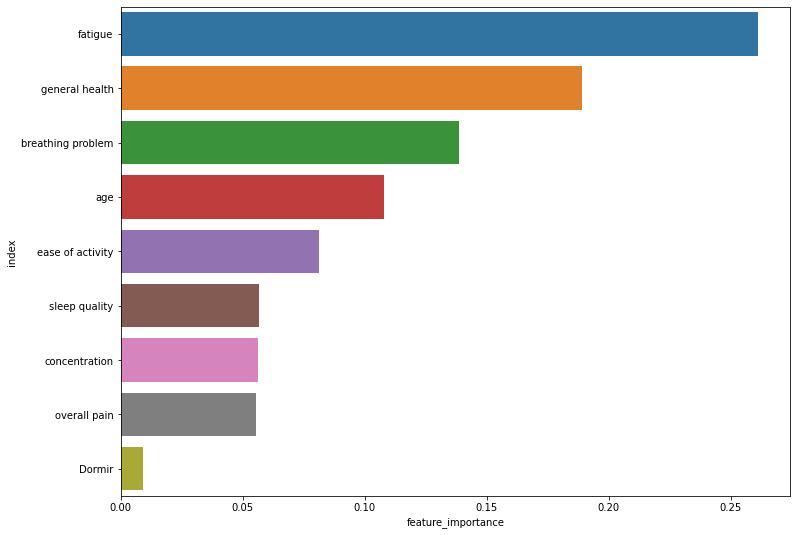

In [25]:
#model = linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=rs_const)
#model = linear_model.Lasso(alpha=0.00545559478116852, random_state=rs_const)
model = RandomForestRegressor(max_features=4,n_estimators=200, min_samples_split=5, 
                              min_samples_leaf=1, random_state=rs_const, n_jobs=-1)

model.fit(X_train, y_train)

varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:9,], ax = ax)

In [26]:
# These 2 linear models (ElasticNet and Lasso) seems to be good to predict score and output very similar results

#model = linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=rs_const)
#model = linear_model.Lasso(alpha=0.00545559478116852, random_state=rs_const)
model = RandomForestRegressor(max_features=4, n_estimators=200, min_samples_split=5, 
                              min_samples_leaf=1, random_state=rs_const, n_jobs=-1)

model.fit(train_data_std, train_target)

final_train_prediction = model.predict(train_data_std)
final_test_prediction  = model.predict(test_data_std)

print("For log severity score: ")
print("RMSE train: {}".format(rmse(train_target, final_train_prediction)))
print("")
print("For actual severity score: ")
print("RMSE train: {}".format(rmse(np.expm1(train_target), np.expm1(final_train_prediction))))

For log severity score: 
RMSE train: 0.4836311145907228

For actual severity score: 
RMSE train: 1113.669616840819


In [27]:
#final_test_prediction = np.expm1(final_test_prediction)

final_submission = pd.DataFrame()
final_submission['severity score'] = final_test_prediction

In [28]:
final_submission

,severity score
0,6.792093
1,5.394450
2,6.213897
3,4.376096
4,5.461739
5,6.274160
6,5.670498
7,5.082898
8,5.479881
9,3.233339


# What we obtain with the formula:

50%(fatigue)+15%(10–mood) + 15%(10–ease of activity) + 20%(10–general health)

MOOD IS CHANGED BY SLEEP QUALITY IN THE CALCUL OF THE FORMULA FOR THE MOMENT 

    severity score:     
0 : 6.4 \
1 : 5.7 \
2 : 5.4\
3 : 2.5\
4 : 8.05\
5 : 6.65 \
6 : 6.3 \
7 : 5.05\
8 : 5.05\
9 : 2.65 

# Try a classification approach !